#**The Correlation between Temperature and Hurricanes in the US**
##Fall 2024 Data Science Project

*An analysis by Nandhini Jey, Amudha Krishnan, Sebastian Nunez, Neha Sanooj, and Natalie Wathen*

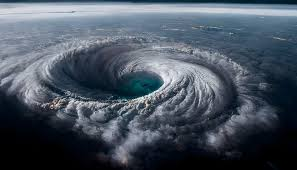

# Introduction

The main purpose of this project is to determine whether there exists a correlation between the number of storms and hurricanes in the contiguous United States and the temperature. With President-elect Trump announcing that he would once again pull the United States from the Paris Climate Accord when he takes office, we believe that it is important to highlight the disastrous effects a lack of sustainable climate action will have. Far too often, storms like these affect communities disproportionately and with this project, it is our goal to make this information and correlation publicly available, to better prepare those for disaster.

As such, we will complete the above described analysis by going through the Data Science Lifecycle as follows:

1. [Data Collection](#Data-Collection)
2. [Data Processing and Curation](#Data-Processing-and-Curation)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Primary Analysis and Visualization](#Primary-Analysis-and-Visualization)
5. [Interpretation](#Interpretation)

<a name="Data-Collection"></a>
# Data Collection

In looking for the appropriate data, we came across the National Oceanic and Atmospheric Administration's [Atlantic hurricane dataset](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Futkarshx27%2Fnoaa-atlantic-hurricane-database) on Kaggle, which is a reliable source from which we can conduct our research. This contains details such as storm name, data, status (whether it is a tropical depression, tropical storm, or hurricane), category, wind, and pressure collected between 1975 and 2021. Additionally, we will be making use of the following [temperature by state dataset](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fthedevastator%2Fanalyzing-u-s-warming-rates-insights-into-climat), which provides insight on the temperature in each state from 1895 to 2019. The dataset includes Federal Information Processing Standard (FIPS) codes (which identifies U.S. states and counties), year, and average temperature in degrees Fahrenheit and Celsius. Lastly, the following temperature dataset from KiltHub (a library research repository from Carnegie Mellon University) organizes [temperature data by city](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488?file=48711145), providing us with a breakdown of the average temperature each year across a selection of 210 US Cities across the contiguous United States (between 1893 and 2023).

We will start by importing the necessary dependencies and downloading the relevant files.

In [8]:
# Importing dependencies
!pip install us

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy.stats import linregress
import us
import zipfile
import os

Here is all the data we will be making use of for the remainder of this research project! Be sure to download the files linked below and then upload them to this project's directory.
>[Atlantic Hurricane Dataset](https://www.kaggle.com/datasets/utkarshx27/noaa-atlantic-hurricane-database)
>> There is only one [storms.csv](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1K0UgE-rOZ_1cvaKzVU8tLNBOE6orUErq%2Fview%3Fusp%3Dsharing) file listed, which is what we will use

>[Temperature by State Dataset](https://www.google.com/url?q=https%3A%2F%2Fwww.google.com%2Furl%3Fq%3Dhttps%253A%252F%252Fwww.kaggle.com%252Fdatasets%252Fthedevastator%252Fanalyzing-u-s-warming-rates-insights-into-climat)
>> We want the [climdiv_state_year.csv](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1Aqv32XF6WZfsNpp4s8sAD9WVwjvWtion%2Fview%3Fusp%3Dsharing) file which has the temperature stored by state

>[Temperature by City Dataset](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488?file=32874374)
>> We download the following [zip file](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F18Ju0RLhd5a0oTA7OmVKEK3X2STpqa7Ql%2Fview%3Fusp%3Dsharing) and then specifically work with the [city_info.csv](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1wYoQNPihqPwC0GS9J9b9EWcQ2d5ZB8NL%2Fview%3Fusp%3Dsharing) file. Be sure to work with the zip file directly from google drive, whereas the csv file can be downloaded to this directory (similar to above).


<a name="Data-Processing-and-Curation"></a>
# Data Processing and Curation

In order to prove our hypothesis, we need to start by analyzing if there is an increase in temperature over the years in the contiguous United States. We start by uploading the relevant csv file and storing it in a dataframe named temps_df. This dataframe will tell us the annual average temperatures for each state in the Lower 48.

In [2]:
# Load the data into the temperature dataframe
temps_df = pd.read_csv('climdiv_state_year.csv')
temps_df

,index,fips,year,temp,tempc
0,0,1,1895,61.641667,16.467593
1,1,1,1896,64.266667,17.925926
2,2,1,1897,64.191667,17.884259
3,3,1,1898,62.983333,17.212963
4,4,1,1899,63.100000,17.277778
...,...,...,...,...,...
5995,5995,56,2015,44.158333,6.754630
5996,5996,56,2016,43.908333,6.615741
5997,5997,56,2017,43.200000,6.222222
5998,5998,56,2018,42.408333,5.782407


For even further detailed data, we will also make use of the city temperature dataset described above. However, we see that this dataset contains over 200 csv files, one for each city. Not only that, but each one has around 130 rows of temperature data, detailing the available daily maximum and minimum temperatures as well as precipitation data. While this data will be incredibly useful to our research, it is a lot to parse through and for that reason we will curate it to only contain the datapoints we absolutely need.

The files are named after their postal codes, and there is one file, *city_info.csv*, which contains the names of the cities as well as other information (postal codes, latitude and longitude, etc). Using this, we will merge all of the different cities' data to create one big dataframe with every cities' temperatures.

In [3]:
# Be careful about running this cell more than once under the same runtime!

# Path to the ZIP file in Google Drive
zip_file_path = 'drive/MyDrive/fall \'24/data science/cmu_temp_data.zip'  # replace with your path to the zip file

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

# Check the extracted files
extracted_path = 'extracted_files'
print(os.listdir(extracted_path))

# List all CSV files
csv_files = [f for f in os.listdir(extracted_path) if f.endswith('.csv')]

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file and process
for file in csv_files:
    file_path = os.path.join(extracted_path, file)
    # Read the CSV file
    df = pd.read_csv(file_path)
    # Extract the postal code from the file name
    postal_code = os.path.splitext(file)[0]
    # Add a new column for the postal code
    df['PostalCode'] = postal_code
    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Merge the combined DataFrame with the city_info DataFrame
city_info = pd.read_csv('city_info.csv')
all_cities_temp_df = pd.merge(combined_df, city_info, left_on='PostalCode', right_on='ID', how='outer')
all_cities_temp_df

['USW00094846.csv', 'USC00166584.csv', 'USW00094298.csv', 'USW00024032.csv', 'USW00014842.csv', 'USW00014991.csv', 'USW00093820.csv', 'USW00013889.csv', 'USW00013957.csv', 'USW00093822.csv', 'USW00094950.csv', 'USW00024163.csv', 'USW00014745.csv', 'USW00024155.csv', 'USC00380072.csv', 'USW00014735.csv', 'USW00014933.csv', 'USW00014792.csv', 'USW00013963.csv', 'USW00013985.csv', 'USC00280734.csv', 'USW00094008.csv', 'USW00014944.csv', 'USW00014753.csv', 'USW00023066.csv', 'USW00094850.csv', 'USW00094908.csv', 'USW00023050.csv', 'USW00014942.csv', 'USW00023044.csv', 'USW00013886.csv', 'USC00356749.csv', 'USW00013737.csv', 'USW00012839.csv', 'USW00003965.csv', 'USW00003947.csv', 'USW00014943.csv', 'USW00014898.csv', 'USW00013895.csv', 'USW00014827.csv', 'USW00004853.csv', 'USW00094949.csv', 'USW00012924.csv', 'USW00023065.csv', 'USW00093037.csv', 'USW00014764.csv', 'USW00013740.csv', 'USW00093812.csv', 'USW00014840.csv', 'USW00093815.csv', '291919797.zip', 'USW00013968.csv', 'USW00023051.

,Unnamed: 0_x,Date,tmax,tmin,prcp,PostalCode,Unnamed: 0_y,Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate
0,1,1894-01-01,60.0,41.0,0.0,USC00042863,402,Escondido,USC00042863,33.1211,-117.0900,Escondido,1894-01-01,1979-03-31
1,1,1894-01-01,60.0,41.0,0.0,USC00042863,403,Escondido,USC00042863,33.1211,-117.0900,Escondido 2,1979-04-01,2023-12-31
2,2,1894-01-02,58.0,50.0,0.4,USC00042863,402,Escondido,USC00042863,33.1211,-117.0900,Escondido,1894-01-01,1979-03-31
3,2,1894-01-02,58.0,50.0,0.4,USC00042863,403,Escondido,USC00042863,33.1211,-117.0900,Escondido 2,1979-04-01,2023-12-31
4,3,1894-01-03,57.0,42.0,0.0,USC00042863,402,Escondido,USC00042863,33.1211,-117.0900,Escondido,1894-01-01,1979-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23411516,47479,2023-12-29,44.1,16.2,0.0,USW00094973,8,Hayward,USW00094973,46.0261,-91.4442,Hayward Muni AP,1998-04-01,2023-12-31
23411517,47480,2023-12-30,30.2,18.1,0.0,USW00094973,7,Hayward,USW00094973,46.0261,-91.4442,Hayward RS,1894-01-01,1998-03-31
23411518,47480,2023-12-30,30.2,18.1,0.0,USW00094973,8,Hayward,USW00094973,46.0261,-91.4442,Hayward Muni AP,1998-04-01,2023-12-31
23411519,47481,2023-12-31,28.2,22.1,0.0,USW00094973,7,Hayward,USW00094973,46.0261,-91.4442,Hayward RS,1894-01-01,1998-03-31


Finally, we need to collect our storm data! As stated above, we will use the NOAA dataset for this. We will upload the necessary csv file and load it into a dataframe.

In [4]:
# Load the data into the storm dataframe
noaa_df = pd.read_csv("storms.csv")
noaa_df

,Unnamed: 0,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
3,4,Amy,1975,6,27,18,30.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
4,5,Amy,1975,6,28,0,31.5,-78.8,tropical depression,NaN,25,1012,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19061,19062,Wanda,2021,11,7,0,37.4,-37.4,tropical storm,NaN,35,1003,60.0,0.0
19062,19063,Wanda,2021,11,7,6,38.1,-36.4,tropical storm,NaN,35,1004,60.0,0.0
19063,19064,Wanda,2021,11,7,12,39.2,-34.9,other low,NaN,35,1006,90.0,0.0
19064,19065,Wanda,2021,11,7,18,40.9,-32.8,other low,NaN,40,1006,90.0,0.0


All the dataframes that we want to work with, temps_df, all_cities_temp_df, and noaa_df are ready to use! We will now begin organizing and filtering the data.

We will start by filtering and organizing the temps_df dataframe. For our purposes, we only want to look at the FIPS code, year, and temperature in degrees Fahrenheit. Let's first filter out any unwanted data:

In [6]:
# Remove the 'index' and 'tempc' columns
temps_df = temps_df[['fips', 'year', 'temp']]
temps_df

,fips,year,temp
0,1,1895,61.641667
1,1,1896,64.266667
2,1,1897,64.191667
3,1,1898,62.983333
4,1,1899,63.100000
...,...,...,...
5995,56,2015,44.158333
5996,56,2016,43.908333
5997,56,2017,43.200000
5998,56,2018,42.408333


Next, we'll work with the FIPS code column. We can translate the FIPS codes to their respective states using the US package, which allows us to easily work with U.S. states and their metadata. We will create a custom fips_to_state function that will return the correct U.S. state based on the parameter, the FIPS code. Use the fips_to_state function to create a new 'State' column for our dataframe:

In [9]:
# Change FIPS code into state names
def fips_to_state(fips):
    state = us.states.lookup(str(fips).zfill(2))  # Ensure FIPS is a 2-digit string
    return state.name if state else None

# Apply the function to the 'fips' column to create a new 'state' column
temps_df['state'] = temps_df['fips'].apply(fips_to_state)

temps_df

,fips,year,temp,state
0,1,1895,61.641667,Alabama
1,1,1896,64.266667,Alabama
2,1,1897,64.191667,Alabama
3,1,1898,62.983333,Alabama
4,1,1899,63.100000,Alabama
...,...,...,...,...
5995,56,2015,44.158333,Wyoming
5996,56,2016,43.908333,Wyoming
5997,56,2017,43.200000,Wyoming
5998,56,2018,42.408333,Wyoming


Our temps_df dataframe is now ready to use for analysis! Let's start organizing the all_cities_temp_df dataframe. We only want to keep the date, tmax, postal code, city name, and latitude/longitude columns. We will drop all the other unwanted columns. We will also drop any rows with missing or N/A data.

In [10]:
all_cities_temp_df = all_cities_temp_df.drop(columns=['ID', 'Stn.Name', 'Stn.stDate', 'Stn.edDate', 'tmin', 'prcp'])
all_cities_temp_df.dropna(inplace=True)
all_cities_temp_df

,Unnamed: 0_x,Date,tmax,PostalCode,Unnamed: 0_y,Name,Lat,Lon
0,1,1894-01-01,60.0,USC00042863,402,Escondido,33.1211,-117.0900
1,1,1894-01-01,60.0,USC00042863,403,Escondido,33.1211,-117.0900
2,2,1894-01-02,58.0,USC00042863,402,Escondido,33.1211,-117.0900
3,2,1894-01-02,58.0,USC00042863,403,Escondido,33.1211,-117.0900
4,3,1894-01-03,57.0,USC00042863,402,Escondido,33.1211,-117.0900
...,...,...,...,...,...,...,...,...
23411516,47479,2023-12-29,44.1,USW00094973,8,Hayward,46.0261,-91.4442
23411517,47480,2023-12-30,30.2,USW00094973,7,Hayward,46.0261,-91.4442
23411518,47480,2023-12-30,30.2,USW00094973,8,Hayward,46.0261,-91.4442
23411519,47481,2023-12-31,28.2,USW00094973,7,Hayward,46.0261,-91.4442


Now, notice how we have several rows for each day of each year for each city. We need to narrow this down! For later analysis, we only want to keep the maximum temperature per year in each city. To do this, start by extracting just the years from the 'Date' column and make a new column 'Year'. We will use the group-by function to select just the maximum value in the tmax column for each year in one city, and repeat this for all the cities. We can drop the 'Date' column as well, since we now have the 'Year' column:

In [11]:
# Extract the year from the 'Date' column
all_cities_temp_df['Date'] = pd.to_datetime(all_cities_temp_df['Date'])
all_cities_temp_df['Year'] = all_cities_temp_df['Date'].dt.year

# Find the maximum temperature for each city and year
idx = all_cities_temp_df.groupby(['Name', 'Year'])['tmax'].idxmax()

# Use the indices to filter the original DataFrame
highest_tmax_per_city_year = all_cities_temp_df.loc[idx].reset_index(drop=True)
highest_tmax_per_city_year = highest_tmax_per_city_year.drop(columns='Date')

highest_tmax_per_city_year

,Unnamed: 0_x,tmax,PostalCode,Unnamed: 0_y,Name,Lat,Lon,Year
0,162,104.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1893
1,558,103.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1894
2,992,101.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1895
3,1288,105.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1896
4,1707,102.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1897
...,...,...,...,...,...,...,...,...
27909,45201,93.0,USW00093824,125,Zaneville,39.9444,-81.8922,2019
27910,45491,93.9,USW00093824,125,Zaneville,39.9444,-81.8922,2020
27911,45836,95.0,USW00093824,125,Zaneville,39.9444,-81.8922,2021
27912,46187,93.9,USW00093824,125,Zaneville,39.9444,-81.8922,2022


Next, let's add 'State' and 'Region' columns. We will use the map function to convert the cities in the 'Name' column to their corresponding states to make the 'State' column. We'll again use the map function to convert the 'State' column into a 'Region' column, which includes the West, Midwest, South, and Northeast.

In [13]:
city_to_state = {
    "Aberdeen": "South Dakota",
    "Abilene": "Texas",
    "Aiken": "South Carolina",
    "Akron": "Ohio",
    "Albany": "New York",
    "Albuquerque": "New Mexico",
    "Amarillo": "Texas",
    "Asheville": "North Carolina",
    "Ashland": "Wisconsin",
    "Astoria": "Oregon",
    "Athens": "Georgia",
    "Atlanta": "Georgia",
    "Augusta": "Georgia",
    "Aurora": "Colorado",
    "Austin": "Texas",
    "Bakersfield": "California",
    "Baltimore": "Maryland",
    "BatonRouge": "Louisiana",
    "Beckley": "West Virginia",
    "Belvidere": "New Jersey",
    "Birmingham": "Alabama",
    "Bismarck": "North Dakota",
    "Bluefield": "West Virginia",
    "Boise": "Idaho",
    "Boston": "Massachusetts",
    "Buffalo": "New York",
    "Burlington": "Vermont",
    "CapeHatteras": "North Carolina",
    "CedarRapids": "Iowa",
    "Charleston": "West Virginia",
    "Charlotte": "North Carolina",
    "Chattanooga": "Tennessee",
    "Cheyenne": "Wyoming",
    "Chicago": "Illinois",
    "Cincinnati": "Ohio",
    "Clayton": "New Mexico",
    "Cleveland": "Ohio",
    "CollegeStation": "Texas",
    "ColoradoSprings": "Colorado",
    "ColumbiaMO": "Missouri",
    "ColumbiaSC": "South Carolina",
    "ColumbusGA": "Georgia",
    "ColumbusOH": "Ohio",
    "Concord": "New Hampshire",
    "Concordia": "Kansas",
    "CorpusChristi" : "Texas",
    "CrescentCity": "California",
    "DallasFortWorth": "Texas",
    "Dayton": "Ohio",
    "Denver": "Colorado",
    "Des Moines": "Iowa",
    "Detroit": "Michigan",
    "DodgeCity": "Kansas",
    "Dubuque": "Iowa",
    "Duluth": "Minnesota",
    "EUGENE": "Oregon",
    "EauClaire": "Wisconsin",
    "El Paso": "Texas",
    "Elko": "Nevada",
    "Ely": "Nevada",
    "Erie": "Pennsylvania",
    "Escondido": "California",
    "Eureka": "California",
    "Evansville": "Indiana",
    "Fargo": "North Dakota",
    "Flagstaff": "Arizona",
    "FortMyers": "Florida",
    "FortSmith": "Arkansas",
    "FortWayne": "Indiana",
    "Fresno": "California",
    "Gainesville": "Florida",
    "Galveston": "Texas",
    "Glasgow": "Montana",
    "GlensFalls": "New York",
    "Goodland": "Kansas",
    "GrandForks": "North Dakota",
    "GrandIsland": "Nebraska",
    "GrandJunction": "Colorado",
    "GrandRapids": "Michigan",
    "GreatFalls": "Montana",
    "GreenBay": "Wisconsin",
    "GreenvilleSpartanburg": "South Carolina",
    "Gulfport": "Mississippi",
    "Harrison": "Arkansas",
    "Hastings": "Nebraska",
    "Hattiesburg": "Mississippi",
    "Havre": "Montana",
    "Hayward": "Wisconsin",
    "Helena": "Montana",
    "Houston": "Texas",
    "Huntington": "West Virginia",
    "Huntsville": "Alabama",
    "Huron": "South Dakota",
    "Indianapolis": "Indiana",
    "InternationalFalls": "Minnesota",
    "Jackson": "Mississippi",
    "Jacksonville": "Florida",
    "Jefferson": "Missouri",
    "Jonesboro": "Arkansas",
    "Kalamazoo": "Michigan",
    "KansasCity": "Kansas",
    "KeyWest": "Florida",
    "KlamathFalls": "Oregon",
    "LaCrosse": "Wisconsin",
    "LakeCharles": "Louisiana",
    "Lander": "Wyoming",
    "Lansing": "Michigan",
    "Lewiston": "Idaho",
    "Lexington": "Kentucky",
    "Lincoln": "Nebraska",
    "LittleRock": "Arkansas",
    "LosAngeles": "California",
    "Louisville": "Kentucky",
    "Lynchburg": "Virginia",
    "Macon": "Georgia",
    "Madison": "Wisconsin",
    "Manchester": "New Hampshire",
    "Marquette": "Michigan",
    "McCook": "Nebraska",
    "Memphis": "Tennessee",
    "Meridian": "Mississippi",
    "Miami": "Florida",
    "MiddletownHarrisburg": "Pennsylvania",
    "Milton": "Massachusetts",
    "Milwaukee": "Wisconsin",
    "Minneapolis": "Minnesota",
    "Missoula": "Montana",
    "Mitchell": "South Dakota",
    "Mobile": "Alabama",
    "Moline": "Illinois",
    "Monroe": "Louisiana",
    "Montgomery": "Alabama",
    "Morgantown": "West Virginia",
    "MuscleShoals": "Alabama",
    "Muskegon": "Michigan",
    "Nashville": "Tennessee",
    "Natchitoches": "Louisiana",
    "Needles": "California",
    "NewBrunswick": "New Jersey",
    "NewYork": "New York",
    "NorfolkNE": "Nebraska",
    "NorfolkVA": "Virginia",
    "NorthPlatte": "Nebraska",
    "Oaklahoma": "Oklahoma",
    "Omaha": "Nebraska",
    "Orlando": "Florida",
    "Pendleton": "Oregon",
    "Pensacola": "Florida",
    "Peoria": "Illinois",
    "Philadelphia": "Pennsylvania",
    "Phoenix": "Arizona",
    "PineBluff": "Arkansas",
    "Pittsburgh": "Pennsylvania",
    "Portland": "Oregon",
    "PortlandME": "Maine",
    "Pueblo": "Colorado",
    "Pullman": "Washington",
    "Raleigh": "North Carolina",
    "Redding": "California",
    "Reno": "Nevada",
    "Richmond": "Virginia",
    "Riverside": "California",
    "RochesterMN": "Minnesota",
    "RochesterNY": "New York",
    "Rockford": "Illinois",
    "Roswell": "New Mexico",
    "Russellville": "Arkansas",
    "Sacramento": "California",
    "Saginaw": "Michigan",
    "SaintCloud": "Minnesota",
    "Salem": "Oregon",
    "SaltLakeCity": "Utah",
    "SanAntonio": "Texas",
    "SanDiego": "California",
    "SaultSteMarie": "Michigan",
    "Savannah": "Georgia",
    "Scottsbluff": "Nebraska",
    "Seattle": "Washington",
    "Shreveport": "Louisiana",
    "SiouxCity": "Iowa",
    "SiouxFalls": "South Dakota",
    "SouthBend": "Indiana",
    "Spencer": "Iowa",
    "Spokane": "Washington",
    "Springfield": "Illinois",
    "SpringfieldMO": "Missouri",
    "StLouis": "Missouri",
    "Stillwater": "Oklahoma",
    "Tallahassee": "Florida",
    "Tampa": "Florida",
    "Toledo": "Ohio",
    "Topeka": "Kansas",
    "Trenton": "New Jersey",
    "TriCities": "Washington",
    "Tucson": "Arizona",
    "Tulsa": "Oklahoma",
    "Ukiah": "California",
    "Valentine": "Arkansas",
    "Vancouver": "Washington",
    "WashingtonDC": "District of Columbia",
    "Waterloo": "Iowa",
    "Wausau": "Wisconsin",
    "WestPalmBeach": "Florida",
    "Wheeling": "West Virginia",
    "Williamsport": "Pennsylvania",
    "Williston": "North Dakota",
    "Wilmington": "Delaware",
    "Winnemucca": "Nevada",
    "Worcester": "Massachusetts",
    "Yuma": "Arizona",
    "Zaneville": "Ohio"
}

state_to_region = {
    # West
    "Washington": "West", "Oregon": "West", "California": "West", "Montana": "West", "Idaho": "West", "Nevada": "West", "Arizona": "West", "Utah": "West", "Wyoming": "West", "Colorado": "West", "New Mexico": "West",
    # Midwest
    "North Dakota": "Midwest", "South Dakota": "Midwest", "Nebraska": "Midwest", "Kansas": "Midwest", "Minnesota": "Midwest", "Iowa": "Midwest", "Missouri": "Midwest", "Wisconsin": "Midwest", "Illinois": "Midwest", "Michigan": "Midwest", "Indiana": "Midwest", "Ohio": "Midwest",
    # South
    "Texas": "South", "Oklahoma": "South", "Arkansas": "South", "Louisiana": "South", "Mississippi": "South", "Alabama": "South", "Tennessee": "South", "Kentucky": "South", "Florida": "South", "Georgia": "South", "South Carolina": "South", "North Carolina": "South", "Virginia": "South", "West Virginia": "South", "Maryland": "South", "Delaware": "South", "District of Columbia": "South",
    # Northeast
    "Pennsylvania": "Northeast", "New Jersey": "Northeast", "New York": "Northeast", "Connecticut": "Northeast", "Rhode Island": "Northeast", "Massachusetts": "Northeast", "Vermont": "Northeast", "Maine": "Northeast", "New Hampshire": "Northeast"
}

highest_tmax_per_city_year['State'] = highest_tmax_per_city_year['Name'].map(city_to_state)
highest_tmax_per_city_year['Region'] = highest_tmax_per_city_year['State'].map(state_to_region)

highest_tmax_per_city_year

,Unnamed: 0_x,tmax,PostalCode,Unnamed: 0_y,Name,Lat,Lon,Year,State,Region
0,162,104.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1893,South Dakota,Midwest
1,558,103.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1894,South Dakota,Midwest
2,992,101.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1895,South Dakota,Midwest
3,1288,105.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1896,South Dakota,Midwest
4,1707,102.0,USW00014929,89,Aberdeen,45.4558,-98.4131,1897,South Dakota,Midwest
...,...,...,...,...,...,...,...,...,...,...
27909,45201,93.0,USW00093824,125,Zaneville,39.9444,-81.8922,2019,Ohio,Midwest
27910,45491,93.9,USW00093824,125,Zaneville,39.9444,-81.8922,2020,Ohio,Midwest
27911,45836,95.0,USW00093824,125,Zaneville,39.9444,-81.8922,2021,Ohio,Midwest
27912,46187,93.9,USW00093824,125,Zaneville,39.9444,-81.8922,2022,Ohio,Midwest


Finally, let's organize our storm data in noaa_df! We will only be looking at hurricanes and tropical storms. Let's create a new dataframe storms_df to contain only the rows from noaa_df that will be useful to us.

For each year, we will select only the hurricanes and tropical storms with the highest category. There are 5 storm categories ranging from 1 to 5, and they are differentiatred by windspeed. A category 1 hurricane's maximum wind speed is 95 mph, while the wind speed of category 5 hurricanes is above 156 mph. We will add these max storms to the storms_df.

We will keep only the necessary columns for our analysis, which are name, year, status, category, wind, and pressure. For further analysis, we will also create a pivot table based on year and category of the storm.

In [32]:
# Initialize a list to hold the processed rows
storms_df = []

# Process data year by year
for year, year_group in noaa_df.groupby("year"):
    for storm, storm_group in year_group.groupby("name"):
        if "hurricane" in storm_group["status"].values:
            hurricane_data = storm_group[storm_group["status"] == "hurricane"]
            max_category_row = hurricane_data.loc[hurricane_data["category"].idxmax()]
            storms_df.append(max_category_row)
        elif "tropical storm" in storm_group["status"].values:
            tropical_storm_data = storm_group[storm_group["status"] == "tropical storm"]
            first_tropical_storm_row = tropical_storm_data.iloc[0]
            storms_df.append(first_tropical_storm_row)

# Combine filtered rows into a new DataFrame
storms_df = pd.DataFrame(storms_df)

storms_df['category'] =  storms_df['category'].fillna(0.5)
storms_df = storms_df.drop(columns=['month', 'day', 'hour','lat','long','tropicalstorm_force_diameter','hurricane_force_diameter'])
storms_df = storms_df.reset_index(drop=True)

print(storms_df)

pivot = storms_df.pivot_table(index='year', columns='category', aggfunc='size', fill_value=0)
pivot

     Unnamed: 0      name  year          status  category  wind  pressure
0             9       Amy  1975  tropical storm       0.5    35      1004
1            45   Blanche  1975       hurricane       1.0    65       987
2            78  Caroline  1975       hurricane       3.0   100       973
3           103     Doris  1975       hurricane       2.0    90       970
4           153    Eloise  1975       hurricane       3.0   105       958
..          ...       ...   ...             ...       ...   ...       ...
582       18895     Peter  2021  tropical storm       0.5    35      1006
583       18913      Rose  2021  tropical storm       0.5    35      1007
584       18944       Sam  2021       hurricane       4.0   115       950
585       18994    Victor  2021  tropical storm       0.5    35      1005
586       19040     Wanda  2021  tropical storm       0.5    40       993

[587 rows x 7 columns]


category,0.5,1.0,2.0,3.0,4.0,5.0
year,,,,,,
1975,2,1,2,2,1,0
1976,1,2,2,2,0,0
1977,1,4,0,0,0,1
1978,6,2,1,0,2,0
1979,3,2,1,0,1,1
1980,2,4,3,1,0,1
1981,4,3,1,2,1,0
1982,3,1,0,0,1,0
1983,1,2,0,1,0,0


Our data is finally curated! We can now move on to performing some basic data analysis, in order to draw initial conclusions.

<a name="Exploratory-Data-Analysis"></a>
# Exploratory Data Analysis

We begin this analysis by presenting three statistical conclusions. This will help us determine the main characteristics of our data, as well as allow us to take a look at the details of our features and labels. Doing this will then influence how we conduct the rest of our research. Let's dive in!

First, we want to determine whether there is a correlation between time and the number of storms observed. To do this, we will observe temperature changes (if there are any) as the years pass.

***Conclusion 1: There is no correlation between the years passing and the number of hurricanes***

$H_{0}$: There is no correlation between the years passing and the number of hurricanes

$H_{a}$: There is a correlation between the years passing and the number of hurricanes

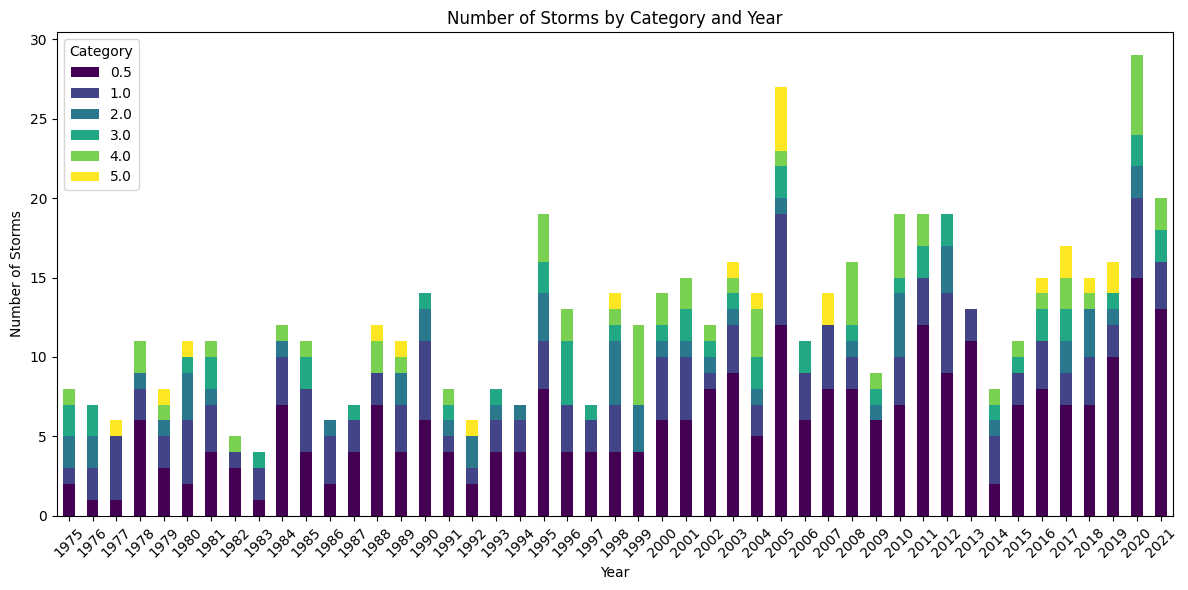

In [35]:
category_year_count = storms_df.groupby(['year', 'category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
category_year_count.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())

# Adding labels and title
plt.title('Number of Storms by Category and Year')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.xticks(rotation=45)
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
# Chi-Square Test to see whether there is a correlation between the number and category of hurricanes and time passing (years)
from scipy.stats import chi2_contingency

# Group and count hurricanes
test_df = storms_df.groupby(['year', 'category']).size().reset_index(name='count')
storms_df

# Create contingency table
contingency_table = pd.crosstab(test_df['year'], test_df['category'])
contingency_table = contingency_table.fillna(0)

# Chi-square test
res = chi2_contingency(contingency_table)
p_value = res.pvalue
print(f'p-value: {p_value}')

# Since the p-value is so large, we know that there is no correlation between the years passing and the number of hurricanes

p-value: 1.0


Now let's determine whether the temperature has even been increasing over time, as a large part of our analysis is dependent upon this.

***Conclusion 2: Temperatures have been increasing over time (1975-2021)***

$H_{0}$: Temperatures have not been increasing over time.

$H_{a}$: Temperatures have been increasing over time.

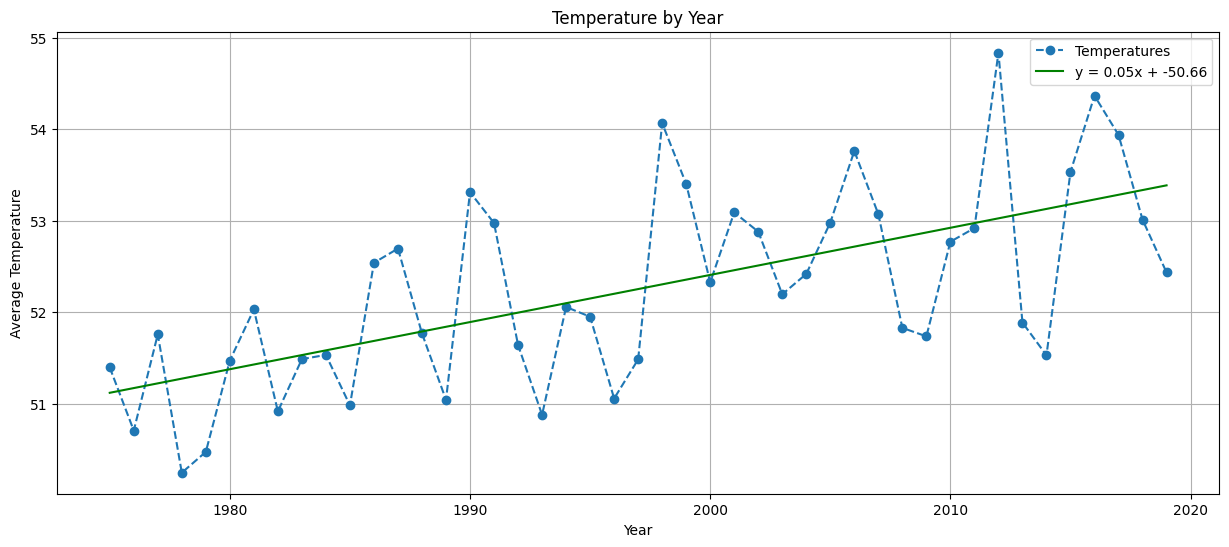

In [39]:
#plot temperature vs year on a line graph

#only keep the year and temperature columns
temp_plot_df = temps_df[['year', 'temp']]

#only keep years 1975-2021 since that all the hurricane data we have
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]

#group the dataframe by the year column and take the average temperature across the states
temp_plot_df = temp_plot_df.groupby('year').mean()

#linear regression

#year
x_values =  temp_plot_df.index
x_values = sm.add_constant(x_values)

#temperature
y_values = temp_plot_df['temp'].values

#linear regression model
lr_model = sm.OLS(y_values, x_values).fit()


#predict temperature  values based on lr model
prediction = lr_model.predict(x_values)

#slope and intercept
slope = lr_model.params[1]
intercept = lr_model.params[0]

#linear regression equation
equation = f"y = {slope:.2f}x + {intercept:.2f}"

#plot
plt.figure(figsize=(15,6))
plt.plot(temp_plot_df.index, temp_plot_df['temp'], label='Temperatures', marker='o', linestyle='--')
plt.plot(temp_plot_df.index, prediction, label=equation.format(slope,intercept), color='green')

plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Temperature by Year')
plt.grid(True)
plt.legend()
plt.show()

After doing a linear regression, the P-value was .05 (slope of the regression line), so we can reject the null hypothesis, and assume the alternate hypothesis. As such, we confirm that temperatures have been increasing over time.

Lastly, we will take a look at the category of a hurricane, and whether this affects its pressure.

***Conclusion 3: The Category of a Hurricane and it's effects on pressure***

$H_{0}$: The Category of a Hurricane does not have an effect on the hurricane's pressure

$H_{a}$: The Category of a Hurricane does have an effect on the hurricane's pressure

p-value: 0.0


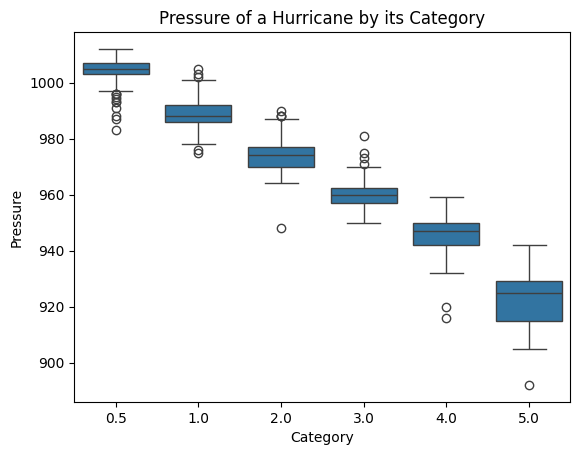

In [41]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

category = [group['pressure'].values for _, group in storms_df.groupby('category')]
f, p = f_oneway(*category)
print(f'p-value: {p}')

sns.boxplot(x='category', y='pressure', data=storms_df)
plt.xlabel('Category')
plt.ylabel('Pressure')
plt.title('Pressure of a Hurricane by its Category')
plt.show()

After applying an Anova test, we can see that the p-value < 0.05. So we reject the null hypothesis, and can accept the alternate hypothesis.

After running these three hypothesis tests, we can conclude that there is no correlation between the number of storms in a year, and that year or over time passing. However, we see that as time has passed the temperature has increased. Additionally we know that the pressure of a hurricane is dependent on its category, as visualized above.

Moving forward with this project, and given the above stated hypothesis analyses, we have determined that the most appropriate machine learning technique for us to use is regression. We are trying to determine a correlation, one that our initial analysis has proved to be linear. As such, it is clear that classification and clustering techniques would not be useful to us, since these tend to group datapoints, whereas we are more focused on predicting a potential correlation.

<a name="Primary-Analysis-and-Visualization"></a>
# Primary Analysis and Visualization

When looking at the effects of climate change, it is important for us to consider the extremes regarding temperature. We previously considered the average temperature experienced over the years, but now let's look at the minimums and maximums. To do this, we will perform linear regression on each feature.

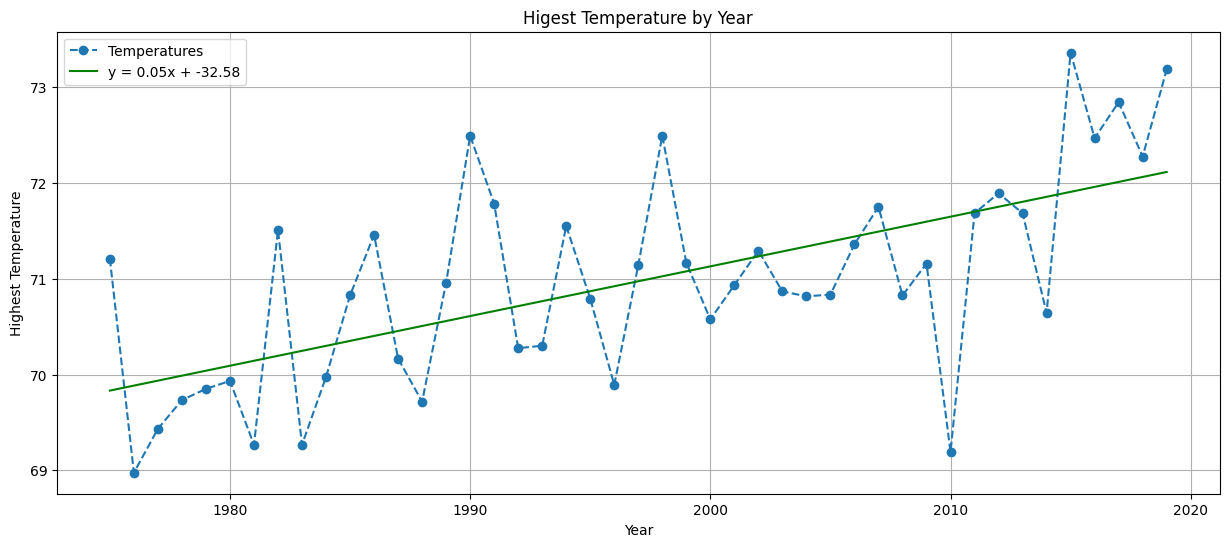

In [42]:
# Plotting maximum temperature vs year on a line graph

# Only keep the year and temperature columns
temp_plot_df = temps_df[['year', 'temp']]

# Only keep years 1975-2021 since thats all the hurricane data we have
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]

# Group the dataframe by the year column and take the maximum temperature across the states
temp_plot_df = temp_plot_df.groupby('year').max()

# Year data
x_values =  temp_plot_df.index
x_values = sm.add_constant(x_values)

y_values = temp_plot_df['temp'].values # Temperature data

lr_model = sm.OLS(y_values, x_values).fit() # Fitting the linear regression model

# Predicting the temperature values based on linear regression model
prediction = lr_model.predict(x_values)

# Determine the slope and intercept
slope = lr_model.params[1]
intercept = lr_model.params[0]

equation = f"y = {slope:.2f}x + {intercept:.2f}"  # Linear regression equation

# Plotting the graph
plt.figure(figsize=(15,6))
plt.plot(temp_plot_df.index, temp_plot_df['temp'], label='Temperatures', marker='o', linestyle='--')
plt.plot(temp_plot_df.index, prediction, label=equation.format(slope,intercept), color='green')
plt.xlabel('Year')
plt.ylabel('Highest Temperature')
plt.title('Higest Temperature by Year')
plt.grid(True)
plt.legend()
plt.show()

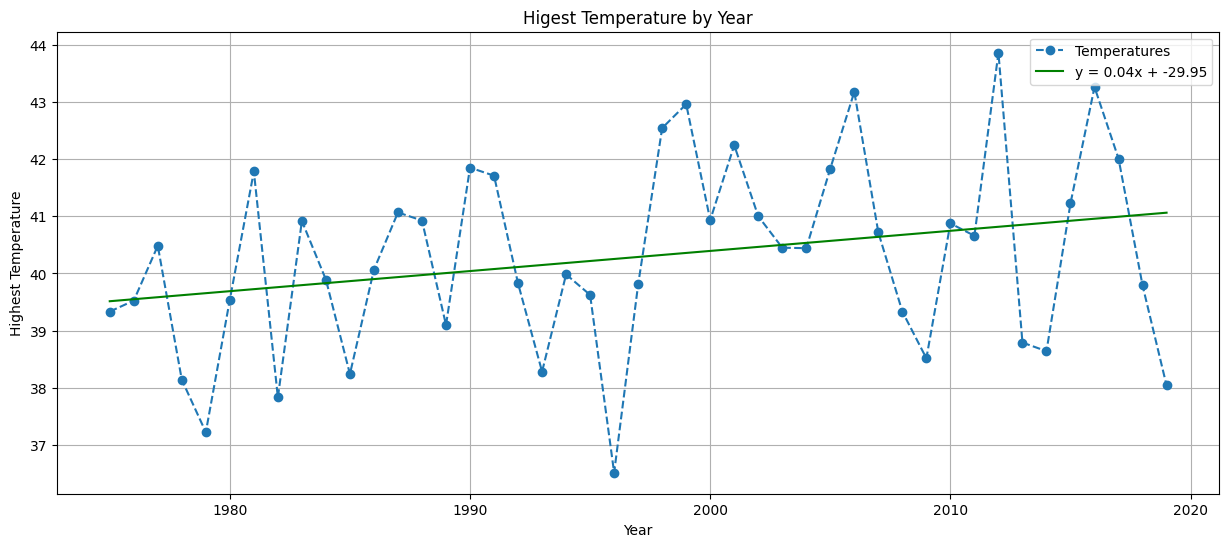

In [43]:
# Plotting minimum temperature vs year on a line graph

# Only keep the year and temperature columns
temp_plot_df = temps_df[['year', 'temp']]

# Only keep years 1975-2021 since thats all the hurricane data we have
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]

# Group the dataframe by the year column and take the minimum temperature across the states
temp_plot_df = temp_plot_df.groupby('year').min()

# Year data
x_values =  temp_plot_df.index
x_values = sm.add_constant(x_values)

y_values = temp_plot_df['temp'].values # Temperature data

lr_model = sm.OLS(y_values, x_values).fit() # Fitting the linear regression model

# Predicting the temperature values based on linear regression model
prediction = lr_model.predict(x_values)

# Determine the slope and intercept
slope = lr_model.params[1]
intercept = lr_model.params[0]

equation = f"y = {slope:.2f}x + {intercept:.2f}"  # Linear regression equation

# Plotting the graph
plt.figure(figsize=(15,6))
plt.plot(temp_plot_df.index, temp_plot_df['temp'], label='Temperatures', marker='o', linestyle='--')
plt.plot(temp_plot_df.index, prediction, label=equation.format(slope,intercept), color='green')
plt.xlabel('Year')
plt.ylabel('Highest Temperature')
plt.title('Higest Temperature by Year')
plt.grid(True)
plt.legend()
plt.show()

For the maximum temperatures we observe a positive slope of 0.05, whereas for minimum temperatures we observe a positive slope of 0.04. Clearly we can see that there exists an upwards trend in temperatures as the years have passed, with maximum temperatures becoming more extreme. ❌

Now that we have determined an increase in temperature, lets see if we can draw any conclusions given the number of hurricanes in a year and time passing. We can do this by plotting the number of storms each year, differentiated by their categories. However let's first create a new dataframe for this step.

In [44]:
# Load the data
data = pd.read_csv("storms.csv")

# Initialize a list to hold the processed rows
hurricanes_df = []

# Process data year by year
for year, year_group in data.groupby("year"):
    for storm, storm_group in year_group.groupby("name"):
        if "hurricane" in storm_group["status"].values:
            hurricane_data = storm_group[storm_group["status"] == "hurricane"]
            max_category_row = hurricane_data.loc[hurricane_data["category"].idxmax()]
            hurricanes_df.append(max_category_row)

# Combine filtered rows into a new DataFrame
hurricanes_df = pd.DataFrame(hurricanes_df)

hurricanes_df['category'] =  hurricanes_df['category'].fillna(0.5)
hurricanes_df = hurricanes_df.drop(columns=['month', 'day', 'hour','lat','long','tropicalstorm_force_diameter','hurricane_force_diameter'])
hurricanes_df = hurricanes_df.reset_index(drop=True)

print(hurricanes_df)

pivot = hurricanes_df.pivot_table(index='year', columns='category', aggfunc='size', fill_value=0)
print(pivot)

     Unnamed: 0      name  year     status  category  wind  pressure
0            45   Blanche  1975  hurricane       1.0    65       987
1            78  Caroline  1975  hurricane       3.0   100       973
2           103     Doris  1975  hurricane       2.0    90       970
3           153    Eloise  1975  hurricane       3.0   105       958
4           168      Faye  1975  hurricane       2.0    85       985
..          ...       ...   ...        ...       ...   ...       ...
305       18684     Henri  2021  hurricane       1.0    65       991
306       18712       Ida  2021  hurricane       4.0   115       950
307       18787     Larry  2021  hurricane       3.0   100       964
308       18836  Nicholas  2021  hurricane       1.0    65       988
309       18944       Sam  2021  hurricane       4.0   115       950

[310 rows x 7 columns]
category  1.0  2.0  3.0  4.0  5.0
year                             
1975        1    2    2    1    0
1976        2    2    2    0    0
1977        

Now for the plot!

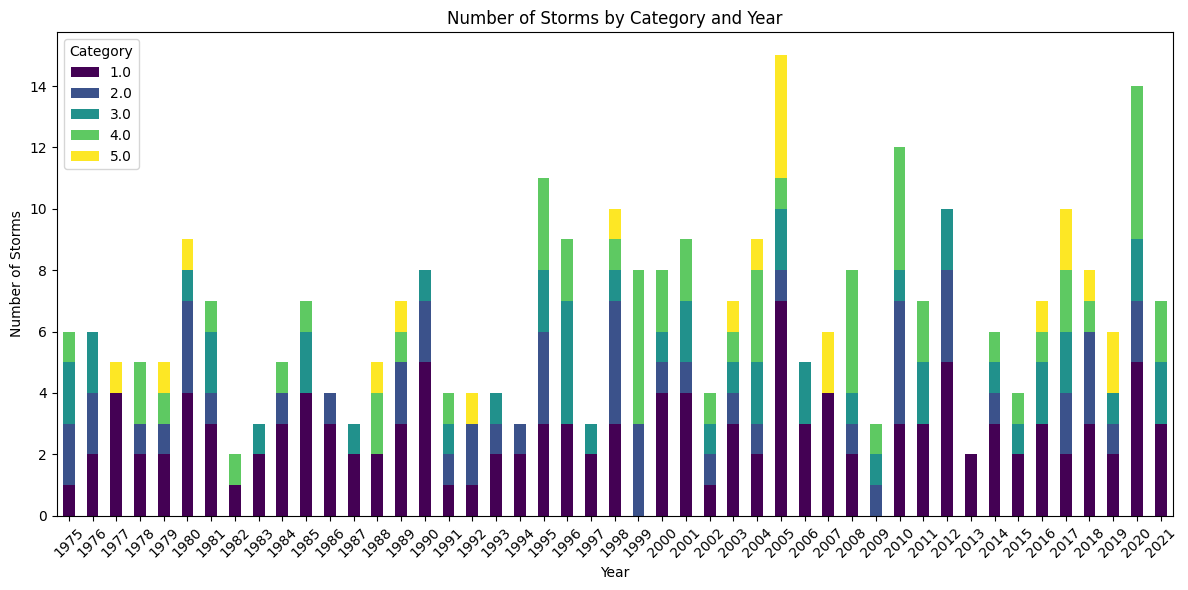

In [45]:
category_year_count = hurricanes_df.groupby(['year', 'category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
category_year_count.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())

# Adding labels and title
plt.title('Number of Storms by Category and Year')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.xticks(rotation=45)
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

This graph gives us a good picture of the hurricane category distribution for each year. Now it's time for our linear regression!

Slope: 0.07203977798334875
P-value: 0.022639699144620804
R-squared: 0.1101857887134577
Reject the null hypothesis


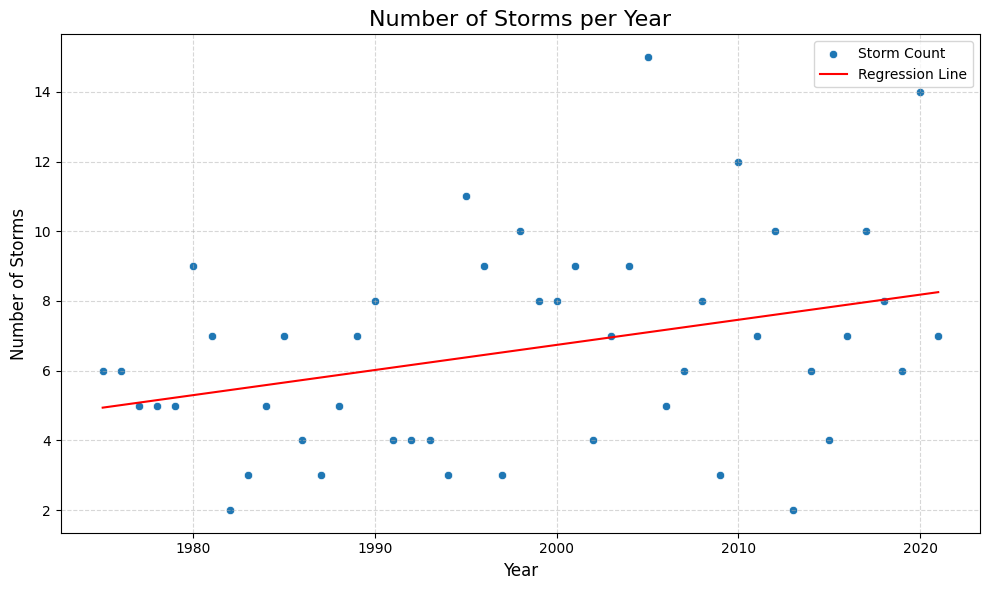

In [46]:
# Prepare the data for regression
storm_counts = hurricanes_df['year'].value_counts().sort_index()
years = storm_counts.index
storm_numbers = storm_counts.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, storm_numbers)

# Print regression results
print(f"Slope: {slope}")
print(f"P-value: {p_value}")
print(f"R-squared: {r_value**2}")

# Hypothesis interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

# Plot the data and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=years, y=storm_numbers, label="Storm Count")
plt.plot(years, intercept + slope * years, color='red', label="Regression Line")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Storms", fontsize=12)
plt.title("Number of Storms per Year", fontsize=16)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now while we can see the correlation between the number of hurricanes and time passing it's not significant enough for us to draw any conclusions. However, there is one thing we have overlooked. When thinking about the effects of rising temperatures, it is not enough for us to simply consider hurricanes. Numerous tropical storms affecting especially vulnerable areas occur every year. In order for us to get a view of the whole picture, it's important for us to consider these datapoints too, so let's include them!

In [47]:
storms_df = []

# Process data year by year
for year, year_group in data.groupby("year"):
    for storm, storm_group in year_group.groupby("name"):
        if "hurricane" in storm_group["status"].values:
            hurricane_data = storm_group[storm_group["status"] == "hurricane"]
            max_category_row = hurricane_data.loc[hurricane_data["category"].idxmax()]
            storms_df.append(max_category_row)
        elif "tropical storm" in storm_group["status"].values:
            tropical_storm_data = storm_group[storm_group["status"] == "tropical storm"]
            first_tropical_storm_row = tropical_storm_data.iloc[0]
            storms_df.append(first_tropical_storm_row)

# Combine filtered rows into a new DataFrame
storms_df = pd.DataFrame(storms_df)

storms_df['category'] =  storms_df['category'].fillna(0.5)
storms_df = storms_df.drop(columns=['month', 'day', 'hour','lat','long','tropicalstorm_force_diameter','hurricane_force_diameter'])
storms_df = storms_df.reset_index(drop=True)

print(storms_df)

pivot = storms_df.pivot_table(index='year', columns='category', aggfunc='size', fill_value=0)
print(pivot)

     Unnamed: 0      name  year          status  category  wind  pressure
0             9       Amy  1975  tropical storm       0.5    35      1004
1            45   Blanche  1975       hurricane       1.0    65       987
2            78  Caroline  1975       hurricane       3.0   100       973
3           103     Doris  1975       hurricane       2.0    90       970
4           153    Eloise  1975       hurricane       3.0   105       958
..          ...       ...   ...             ...       ...   ...       ...
582       18895     Peter  2021  tropical storm       0.5    35      1006
583       18913      Rose  2021  tropical storm       0.5    35      1007
584       18944       Sam  2021       hurricane       4.0   115       950
585       18994    Victor  2021  tropical storm       0.5    35      1005
586       19040     Wanda  2021  tropical storm       0.5    40       993

[587 rows x 7 columns]
category  0.5  1.0  2.0  3.0  4.0  5.0
year                                  
1975      

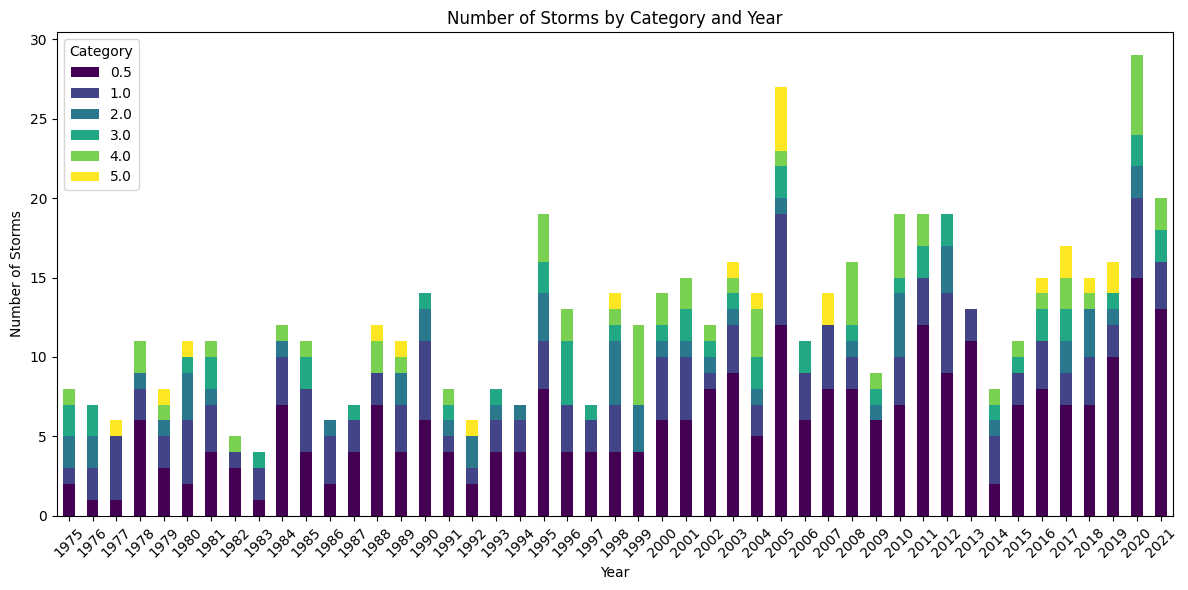

In [48]:
category_year_count = storms_df.groupby(['year', 'category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
category_year_count.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())

# Adding labels and title
plt.title('Number of Storms by Category and Year')
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.xticks(rotation=45)
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

Slope: 0.24687789084181314
P-value: 1.5301293269092404e-06
R-squared: 0.4049060500886165
Reject the null hypothesis


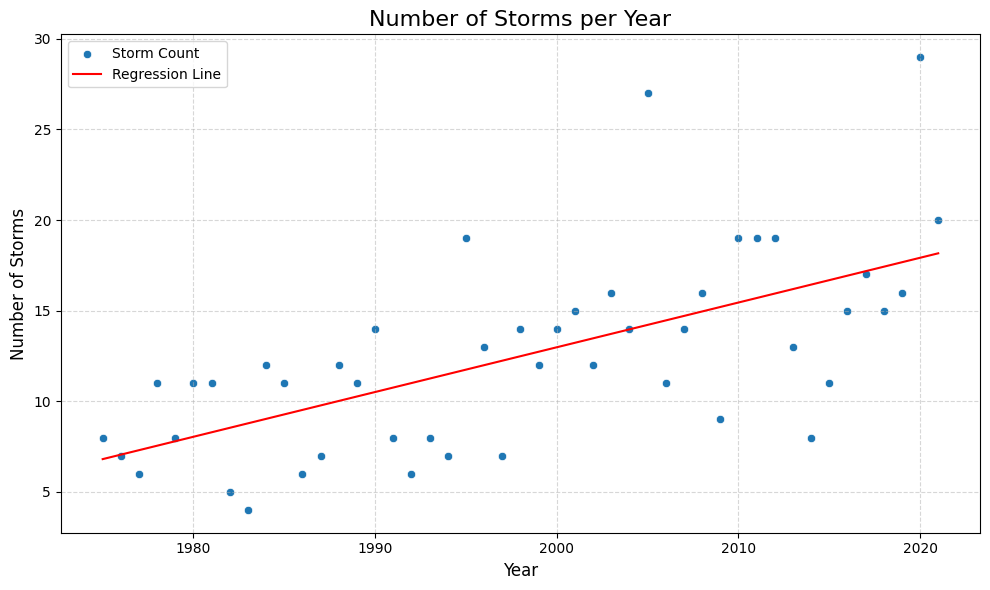

In [49]:
# Prepare the data for regression
storm_counts = storms_df['year'].value_counts().sort_index()
years = storm_counts.index
storm_numbers = storm_counts.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, storm_numbers)

# Print regression results
print(f"Slope: {slope}")
print(f"P-value: {p_value}")
print(f"R-squared: {r_value**2}")

# Hypothesis interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

# Plot the data and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=years, y=storm_numbers, label="Storm Count")
plt.plot(years, intercept + slope * years, color='red', label="Regression Line")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Storms", fontsize=12)
plt.title("Number of Storms per Year", fontsize=16)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Look at how much lower our p-value is now! We can now confidently conclude that there has been an uptick in the number of storms in general with each passing year!

But we can even take this one step further! Hurricanes of a higher category tend to be much more dangerous and as such cause much more damage and harm. So let's see if there has been an increase in higher category hurricanes over the years. To do this, we will assign each storm a weight, depending on its category (with tropical storms receiving a weight of 0.5 and category fives a weight of 5).

In [50]:
weighted_storms = storms_df.groupby('year', as_index=False)['category'].sum()
weighted_storms

,year,category
0,1975,16.0
1,1976,12.5
2,1977,9.5
3,1978,15.0
4,1979,14.5
5,1980,19.0
6,1981,17.0
7,1982,6.5
8,1983,5.5
9,1984,12.5


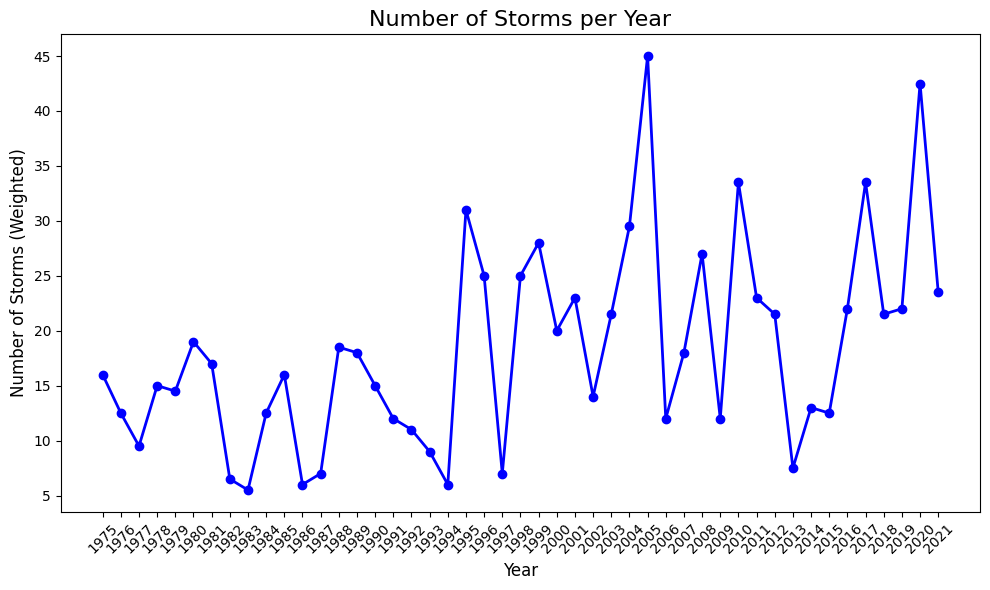

In [51]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(weighted_storms['year'], weighted_storms['category'] , marker='o', color='blue', linestyle='-', linewidth=2)

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Storms (Weighted)', fontsize=12)
plt.title('Number of Storms per Year', fontsize=16)
plt.xticks(weighted_storms['year'], fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Slope: 0.3219
P-value: 0.0007
R-squared: 0.2269
Reject the null hypothesis: There is evidence that the weighted number of storms increases over the years.


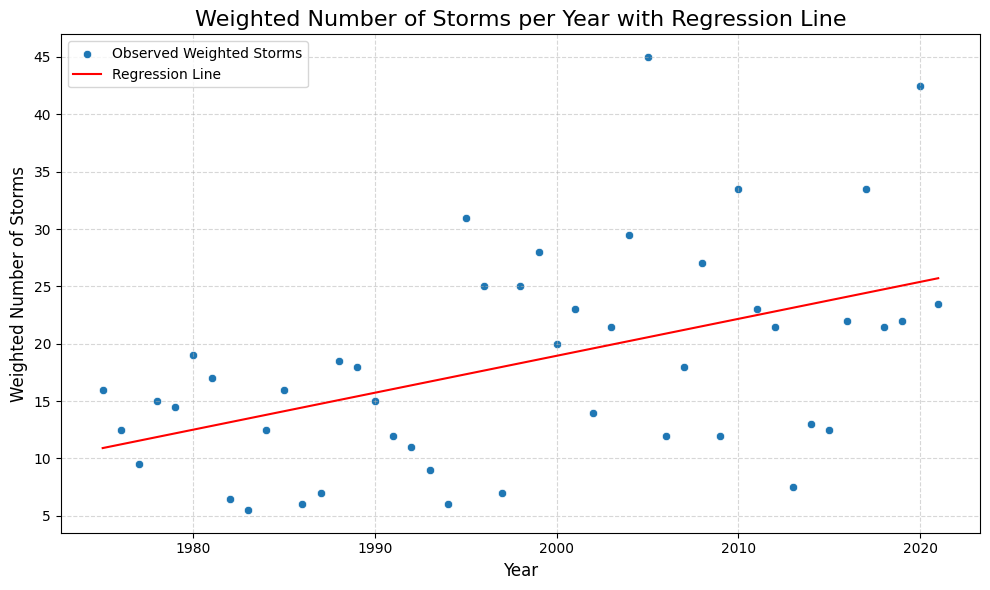

In [52]:
years = weighted_storms['year']
weighted_values = weighted_storms['category']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, weighted_values)

# Print regression results
print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Hypothesis interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence that the weighted number of storms increases over the years.")
else:
    print("Fail to reject the null hypothesis: There is no significant evidence that the weighted number of storms increases over the years.")

# Plot the data and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=years, y=weighted_values, label="Observed Weighted Storms")
plt.plot(years, intercept + slope * years, color='red', label="Regression Line")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Weighted Number of Storms", fontsize=12)
plt.title("Weighted Number of Storms per Year with Regression Line", fontsize=16)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

While this isn't as decisive of a conclusion, just by looking at the weightage we notice that it increases over the years. Therefore, we can draw one of three conclusions: say that the overall number of storms has increased over the years, the intensity/category of the storms has overall increased over time, or both.

Finally, let's take a look at the primary analysis we have been building up to. Does there exist a correlation between the temperature and the number of hurricanes in a given year? Let's find out!

Let's take a look at the minimum, maximum, and average temperature for each year.

Slope: 0.9312
P-value: 0.0251
R-squared: 0.1114
Reject the null hypothesis: There is evidence that as tempreture increases the number of storms increases.


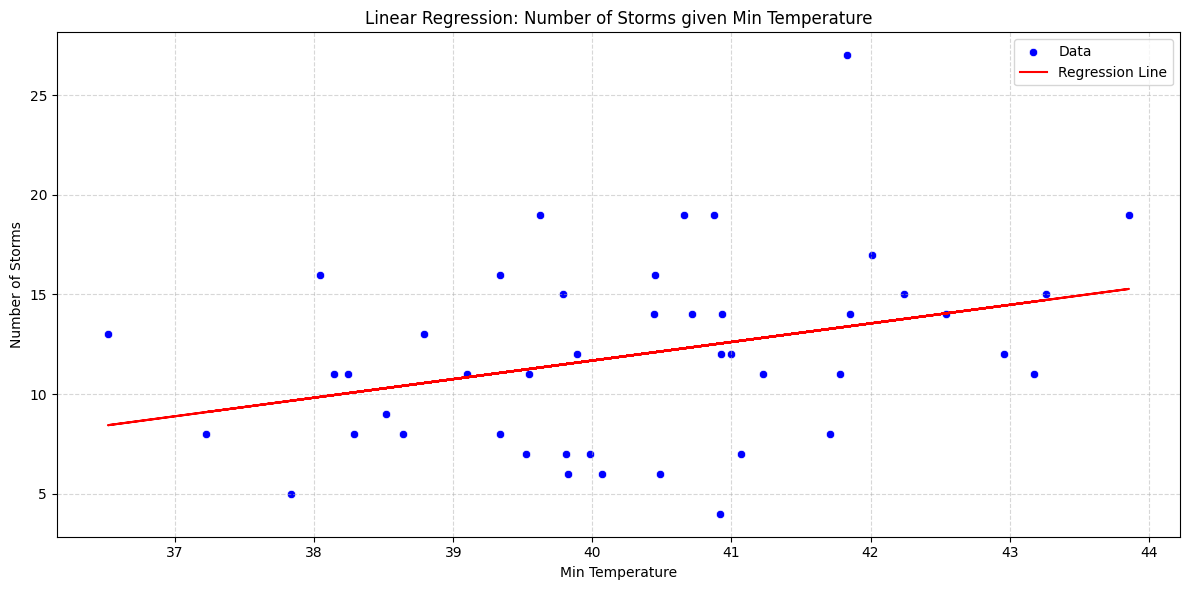

In [53]:
# Minimum Temperature vs. Number of Storms
storm_df = storm_counts.reset_index()
storm_df.columns = ['year', 'storm_count']
temp_plot_df = temps_df[['year', 'temp']]
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]
temp_plot_df = temp_plot_df.groupby('year').min()
# Merge temperature data with storm counts on the year column
merged_df = temp_plot_df.merge(storm_df, left_index=True, right_on='year')

# Step 2: Perform linear regression
x_values = merged_df['temp']  # Min temperature
y_values = merged_df['storm_count']  # Number of storms

slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence that as tempreture increases the number of storms increases.")
else:
    print("Fail to reject the null hypothesis: There is no significant evidence that as tempreture increases the number of storms increases.")

# Step 3: Plot the data and regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(x=x_values, y=y_values, label='Data', marker='o', color='blue')
plt.plot(x_values, intercept + slope * x_values, color='red', label="Regression Line")

# Add labels and title
plt.xlabel('Min Temperature')
plt.ylabel('Number of Storms')
plt.title('Linear Regression: Number of Storms given Min Temperature')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Slope: 1.2129
P-value: 0.0604
R-squared: 0.0796
Fail to reject the null hypothesis: There is no significant evidence that as tempreture increases the number of storms increases.


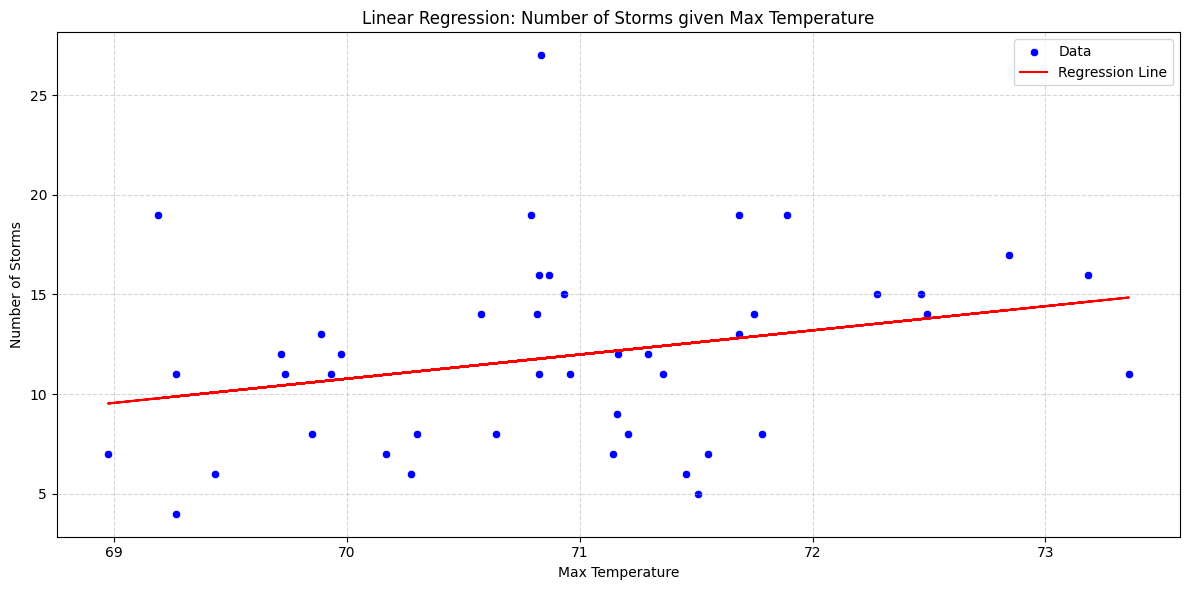

In [54]:
# Maximum Temperature vs. Number of Storms
storm_df = storm_counts.reset_index()
storm_df.columns = ['year', 'storm_count']
temp_plot_df = temps_df[['year', 'temp']]
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]
temp_plot_df = temp_plot_df.groupby('year').max()
# Merge temperature data with storm counts on the year column
merged_df = temp_plot_df.merge(storm_df, left_index=True, right_on='year')

# Step 2: Perform linear regression
x_values = merged_df['temp']  # Max temperature
y_values = merged_df['storm_count']  # Number of storms

slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence that as tempreture increases the number of storms increases.")
else:
    print("Fail to reject the null hypothesis: There is no significant evidence that as tempreture increases the number of storms increases.")

# Step 3: Plot the data and regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(x=x_values, y=y_values, label='Data', marker='o', color='blue')
plt.plot(x_values, intercept + slope * x_values, color='red', label="Regression Line")

# Add labels and title
plt.xlabel('Max Temperature')
plt.ylabel('Number of Storms')
plt.title('Linear Regression: Number of Storms given Max Temperature')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Slope: 2.1725
P-value: 0.0005
R-squared: 0.2509
Reject the null hypothesis: There is evidence that as tempreture increases the number of storms increases.


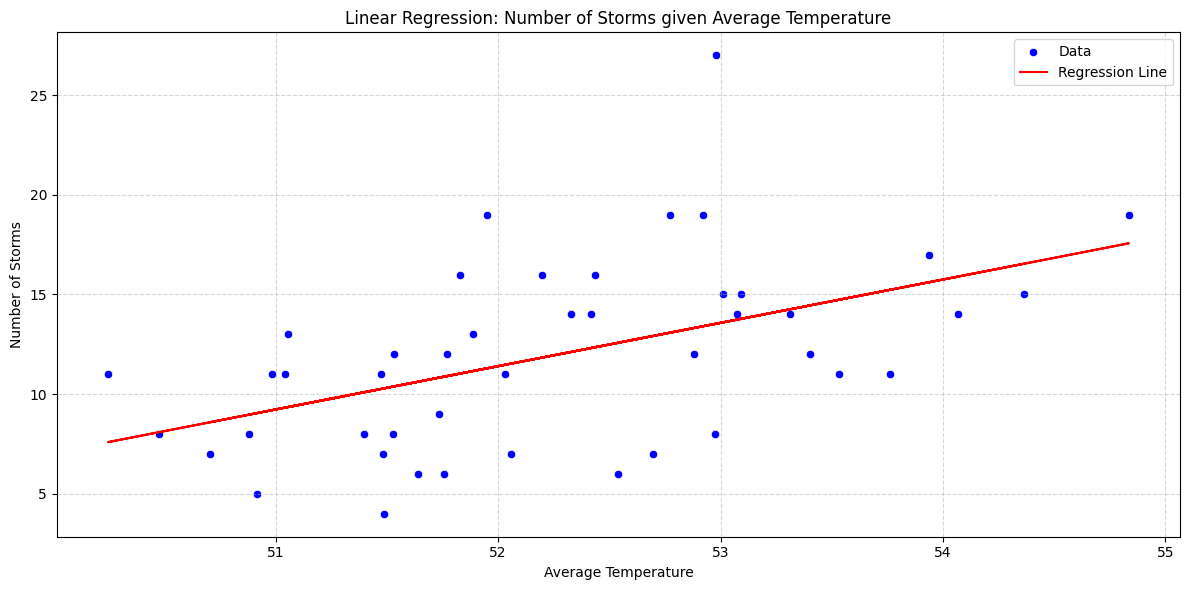

In [55]:
# Average Temperature vs. Number of Storms
storm_df = storm_counts.reset_index()
storm_df.columns = ['year', 'storm_count']
temp_plot_df = temps_df[['year', 'temp']]
temp_plot_df = temp_plot_df[temp_plot_df['year'].between(1975, 2021)]
temp_plot_df = temp_plot_df.groupby('year').mean()
# Merge temperature data with storm counts on the year column
merged_df = temp_plot_df.merge(storm_df, left_index=True, right_on='year')

# Step 2: Perform linear regression
x_values = merged_df['temp']  # Average temperature
y_values = merged_df['storm_count']  # Number of storms

slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence that as tempreture increases the number of storms increases.")
else:
    print("Fail to reject the null hypothesis: There is no significant evidence that as tempreture increases the number of storms increases.")

# Step 3: Plot the data and regression line
plt.figure(figsize=(12, 6))
sns.scatterplot(x=x_values, y=y_values, label='Data', marker='o', color='blue')
plt.plot(x_values, intercept + slope * x_values, color='red', label="Regression Line")

# Add labels and title
plt.xlabel('Average Temperature')
plt.ylabel('Number of Storms')
plt.title('Linear Regression: Number of Storms given Average Temperature')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Wow! With all three, we were able to reject the null hypothesis. Looks like it's officially safe to conclude that rising temperature is directly correlated to an increase in the number of storms.

<a name="Interpretation"></a>
# Interpretation

 Based on all of our analysis, we can draw the following conclusions:
 - There exists a correlation between the rising temperature



 Therefore it's plausible that these numbers are only going to increase as time passes and temperatures increase.